# Tutorial 6: Simple Surface Processes

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

loaded rc file /Users/benknight/Documents/Research/PyVenv/UW2/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
# Characteristic values of the system
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
model_height = 120e3 * u.meter
refViscosity = 1e24 * u.pascal * u.second
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

In [4]:
Model = GEO.Model(elementRes=(32, 32, 32), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(120. * u.kilometer, 120. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, 0.0, -9.81 * u.meter / u.second**2))

	Global element size: 32x32x32
	Local offset of rank 0: 0x0x0
	Local range of rank 0: 32x32x32
In func WeightsCalculator_CalculateAll(): for swarm "JM5Y7ZPD__swarm"
	done 33% (10923 cells)...
	done 67% (21846 cells)...
	done 100% (32768 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "JM5Y7ZPD__swarm"


In [5]:
Model.outputDir="outputs_tutorial6.3_velSP_3D"

In [6]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

In [7]:
air               = Model.add_material(name="Air", shape=GEO.shapes.Layer3D(top=Model.top, bottom=0.0 * u.kilometer))
# stickyAir         = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer2D(top=air.bottom, bottom= 0.0 * u.kilometer))
uppercrust        = Model.add_material(name="UppperCrust", shape=GEO.shapes.Layer3D(top=air.bottom, bottom=-35.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer3D(top=uppercrust.bottom, bottom=-100.0 * u.kilometer))
mantle            = Model.add_material(name="Mantle", shape=GEO.shapes.Layer3D(top=mantleLithosphere.bottom, bottom=Model.bottom))
sediment          = Model.add_material(name="Sediment")

In [8]:
air.diffusivity = 1.0e-6 * u.metre**2 / u.second
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

# stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second
# stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [9]:
air.density                = 1. * u.kilogram / u.metre**3
# stickyAir.density          = 1. * u.kilogram / u.metre**3
uppercrust.density         = GEO.LinearDensity(reference_density=2620. * u.kilogram / u.metre**3)
mantleLithosphere.density  = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
mantle.density             = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
sediment.density           = GEO.LinearDensity(reference_density=2300. * u.kilogram / u.metre**3)

In [10]:
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
sediment.radiogenicHeatProd   = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02 * u.microwatt / u.meter**3

In [11]:
rh = GEO.ViscousCreepRegistry()

In [12]:
air.viscosity                = 1e19 * u.pascal * u.second
# stickyAir.viscosity          = 1e20 * u.pascal * u.second
uppercrust.viscosity         = 1 * rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
mantleLithosphere.viscosity  = rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993
mantle.viscosity             = 0.2 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993
sediment.viscosity           = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

In [13]:
plasticity = GEO.DruckerPrager(cohesion=20.0 * u.megapascal,
                               cohesionAfterSoftening=20 * u.megapascal,
                               frictionCoefficient=0.12,
                               frictionAfterSoftening=0.02,
                               epsilon1=0.5,
                               epsilon2=1.5)

In [14]:
uppercrust.plasticity         = plasticity
mantleLithosphere.plasticity  = plasticity
mantle.plasticity             = plasticity
sediment.plasticity           = plasticity

## Temperature Boundary Condition

In [15]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(mantle, 1603.15 * u.degK), (air, 293.15 * u.degK)])

## Velocity Boundary Conditions

In [16]:
vel = 2.5 * u.centimeter / u.year



vol_out = 2*(vel*(air.top - air.bottom)*Model.maxCoord[1]).to_base_units()
vol_out

1.9012852688417368 <Unit('meter ** 3 / second')>

In [17]:
### Velocity at surface to replace air that gets removed at sides
vel_in = vol_out / (Model.maxCoord[0] * Model.maxCoord[1])
vel_in.to_base_units()

1.320336992251206e-10 <Unit('meter / second')>

In [18]:
Model.set_velocityBCs(left = [-vel, None, None],
                      right=[vel, None, None],
                      front=[None, 0.0, None], back=[None, 0.0, None],
                      top = [None, None, -1*vel_in],
                      bottom = [None, None, None])

## Initial Damage

In [19]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:] = 0.
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,2], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))

In [20]:
if GEO.nProcs == 1:
    Fig = vis.Figure(resolution=(1200,600))
    Fig.Surface(Model.mesh, Model.plasticStrain, cullface=False, opacity=0.5)
    Fig.window()

In [21]:
if GEO.nProcs == 1:
    Fig = vis.Figure(resolution=(1200,600))
    Fig.Surface(Model.mesh, Model.materialField, cullface=False, opacity=0.5)
    Fig.window()

### x and y coordinates for the surface

In [22]:
import numpy as np

x = np.linspace(Model.minCoord[0], Model.maxCoord[0], 2*(Model.mesh.elementRes[0]+1))
y = np.linspace(Model.minCoord[1], Model.maxCoord[1], 2*(Model.mesh.elementRes[1]+1))

xi, yi = np.meshgrid(x, y)

coords = np.zeros(shape=(xi.flatten().shape[0], 3))
coords[:,0] = xi.flatten()
coords[:,1] = yi.flatten()
coords[:,2] = np.zeros_like(coords[:,0]) ### or any array with same shape as x and y coords with the initial height

### add back in the dim
coords = coords * u.kilometer

/var/folders/0v/6_65d96s7sgggt8x4wm2qqz40000gn/T/ipykernel_51205/2453750398.py:9: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords[:,0] = xi.flatten()
/var/folders/0v/6_65d96s7sgggt8x4wm2qqz40000gn/T/ipykernel_51205/2453750398.py:10: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords[:,1] = yi.flatten()


### Include erosion and sedimentation rates in model runs

A branching condition is used to create erosion and sedimentation rates that can vary across the domain

In [23]:
ve_conditions = fn.branching.conditional([((Model.y >= GEO.nd(Model.maxCoord[1])/2.), GEO.nd(2.5 * u.millimeter/u.year)),
                                            (True, GEO.nd(0.0 * u.millimeter/u.year))])

vs_conditions = fn.branching.conditional([((Model.y >= GEO.nd(Model.maxCoord[1])/2.), GEO.nd(2.5 * u.millimeter/u.year)),
                                          (True, GEO.nd(0.0 * u.millimeter/u.year))])

Model.surfaceProcesses = GEO.surfaceProcesses.velocitySurface3D(airIndex     = air.index,
                                                               sedimentIndex= sediment.index,
                                                               surfaceArray = coords,                ### grid with surface points (x, y, z)
                                                               vs_condition = vs_conditions,         ### sedimentation rate at each grid point
                                                               ve_condition = ve_conditions,         ### erosion rate at each grid point
                                                               surfaceElevation=air.bottom)

UNSUPPORTED (log once): POSSIBLE ISSUE: unit 0 GLD_TEXTURE_INDEX_2D is unloadable and bound to sampler type (Float) - using zero texture because texture unloadable



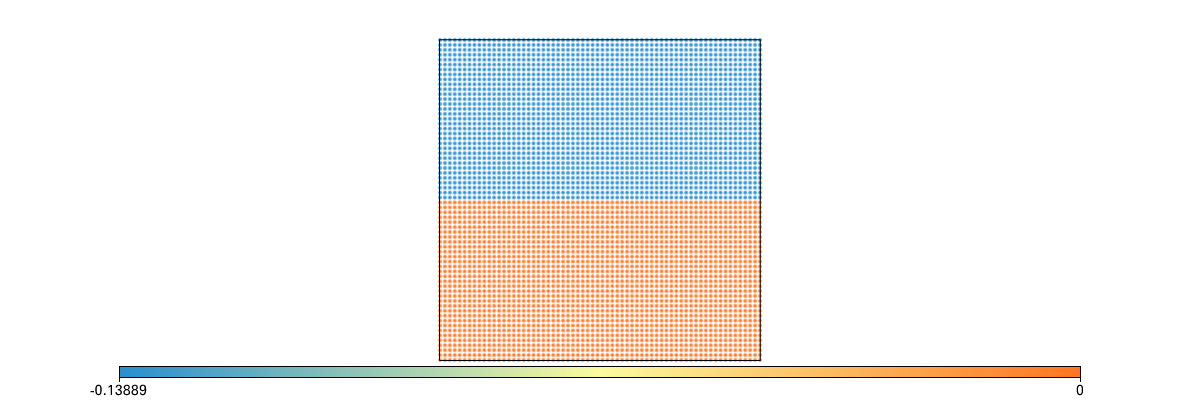

In [24]:
from underworld import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.surface_tracers, Model.surface_tracers.ve, fn_size=5)
Fig.show()


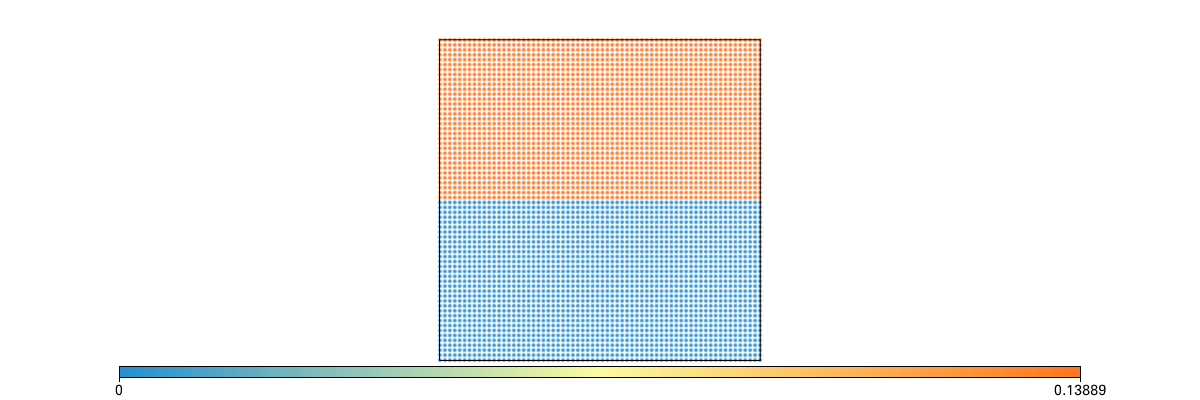

In [25]:
from underworld import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.surface_tracers, Model.surface_tracers.vs, fn_size=5)
Fig.show()

In [26]:
Model.init_model(temperature="steady-state", pressure="lithostatic")

In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Linear solver (ZZFERR92__system-execute) 
Linear solver (ZZFERR92__system-execute), solution time 2.955800e-02 (secs)
Non linear solver - iteration 1
Linear solver (ZZFERR92__system-execute) 
Linear solver (ZZFERR92__system-execute), solution time 2.844200e-02 (secs)
In func SystemLinearEquations_NonLinearExecute: Iteration 1 of 500 - Residual 0.002119 - Tolerance = 0.01
Non linear solver - Residual 2.11901424e-03; Tolerance 1.0000e-02 - Converged - 1.293648e+00 (secs)

In func SystemLinearEquations_NonLinearExecute: Converged after 1 iterations.


In [27]:
GEO.rcParams['initial.nonlinear.min.iterations'] = 1
GEO.rcParams['nonlinear.min.iterations'] = 1

In [28]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-2

In [29]:
Model.run_for(1.01 * u.megayear, checkpoint_interval=0.5*u.megayears)

Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Linear solver (WG3GI2FG__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.171495 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.1027 secs / 1 its
  Pressure Solve:         = 0.2847 secs / 4 its
  Final V Solve:          = 0.068 secs / 1 its

  Total BSSCR Linear solve time: 5.718435 seconds

Linear solver (WG3GI2FG__system-execute), solution time 5.721294e+00 (secs)

1

/Users/benknight/Documents/Research/PyVenv/UW2/lib/python3.10/site-packages/numpy/ma/core.py:2826: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/benknight/Documents/Research/PyVenv/UW2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4339: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  c = np.asanyarray(c, dtype=float)


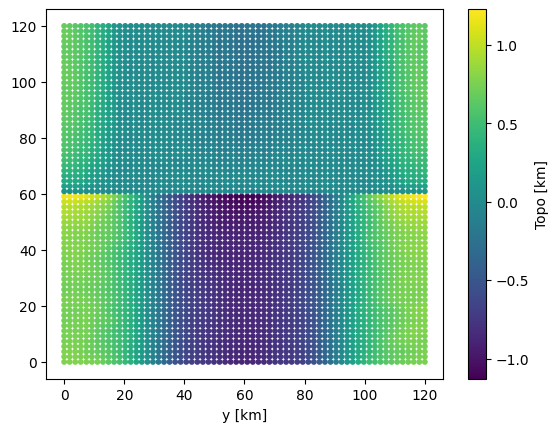

/Users/benknight/Documents/Research/PyVenv/UW2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


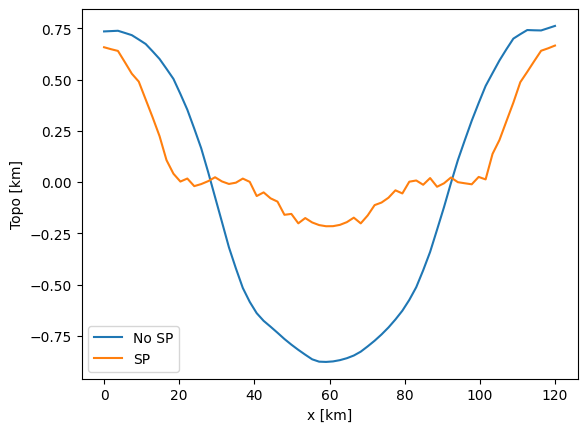

In [30]:
if uw.mpi.rank == 0 :
    import matplotlib.pyplot as plt
    
    
    surface = GEO.dim(Model.surface_tracers.data, u.kilometer)

    scatter = plt.scatter(surface[:,0], surface[:,1], c=surface[:,2], s=10)

    cbar = plt.colorbar(scatter)
    
    cbar.set_label('Topo [km]')
    
    
    plt.xlabel('x [km]')
    plt.xlabel('y [km]')
    
    plt.show()
    
    
    plt.plot()
                  
    profile1 = surface[surface[:,1].m == 24]
    profile2 = surface[surface[:,1].m == 96]
                        
    plt.plot(profile1[:,0], profile1[:,2], label = 'No SP') 
                          
    plt.plot(profile2[:,0], profile2[:,2], label = 'SP')
    
    plt.xlabel('x [km]')
    
    plt.ylabel('Topo [km]')
    
    plt.legend()
    
    